In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner

import seaborn as sns
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

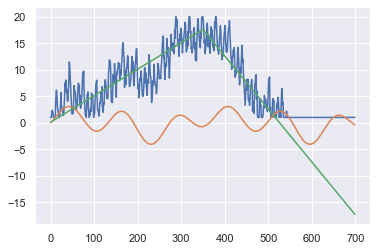

In [2]:
P = 365
P2 = 30.5
N = 700
t = np.arange(N)

# Coefficients
an = [1, 0.5, -1.5]
bn = [1, -0.5, 1.5]

an2 = [-1, 0.5, -1.5]
bn2 = [1, -0.5, 2]

s = [a*np.cos(2*np.pi*(n+1)*t/P) + b*np.sin(2*np.pi*(n+1)*t/P)
     for n,(a,b) in enumerate(zip(an, bn))]
s2 = [a*np.cos(2*np.pi*(n+1)*t/P2) + b*np.sin(2*np.pi*(n+1)*t/P2)
     for n,(a,b) in enumerate(zip(an2, bn2))]

trend = 0.05*t + 0.1
trend[t>350] = -0.1*(t[t>350] - 350) + trend[t==350]

y = sum(s) + sum(s2) + trend
noise = np.random.randn(*y.shape)
y += noise
y = np.clip(y, 1, 20)

plt.plot(t, y)
plt.plot(t, sum(s))
# plt.plot(t, sum(s2))
plt.plot(t, trend)
plt.show()

In [3]:
class TimeSeries(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return torch.Tensor([self.x[i]]), torch.Tensor([self.y[i]])

In [4]:
train_len = int(0.8*len(y))
train_ds = TimeSeries(t[:train_len], y[:train_len])
test_ds = TimeSeries(t[train_len:], y[train_len:])
bs = 96
db = DataBunch.create(train_ds, test_ds, bs=bs)

In [5]:
class FourierModel(nn.Module):
    def __init__(self, y_n=7, m_n=5, w_n=0, 
                 P1=365.25, P2=30.5, P3=7):
        super().__init__()
        self.y_n, self.m_n, self.w_n = y_n, m_n, w_n
        np = [(n+1, P1) for n in range(y_n)]
        np += [(n+1, P2) for n in range(m_n)]
        np += [(n+1, P3) for n in range(w_n)]
        self.np = np
        self.linear = nn.Linear(2*len(np), 1, bias=False)
        
    def forward(self, x):
        cos = [torch.cos(2*np.pi*n*x/p) for n,p in self.np]
        sin = [torch.sin(2*np.pi*n*x/p) for n,p in self.np]
        x = torch.cat(cos + sin, dim=1)
                
        return self.linear(x)

In [26]:
class Squasher(nn.Module):
    def __init__(self, low, high, alpha=0.01):
        super().__init__()
        self.L, self.H, self.alpha = low, high, alpha
    def forward(self, x): 
        x[x < self.L] = self.alpha * (x[x < self.L] - self.L) + self.L
        x[x > self.H] = self.alpha * (x[x > self.H] - self.H) + self.H
        return x

In [38]:
class Trend(nn.Module):
    """
    Broken Trend model, with breakpoints as defined by user.
    """
    def __init__(self, breakpoints):
        super().__init__()
        self.bpoints = breakpoints
        self.init_layer = nn.Linear(1,1) # first linear bit
        self.init_layer.weight.data = torch.Tensor([0.])
        self.init_layer.bias.data = torch.Tensor([0.])
#         import pdb; pdb.set_trace()
            
        if len(breakpoints>0):
            # create deltas which is how the gradient will change
            deltas = torch.zeros(len(breakpoints)) / len(breakpoints) # initialisation
            self.deltas = nn.Parameter(deltas) # make it a parameter
        
    def __copy2array(self):
        """
        Saves parameters into wb
        """
        # extract gradient and bias
        w = self.init_layer.weight
        b = self.init_layer.bias
        self.params = [[w,b]] # save it to buffer
        for d, x1 in zip(self.deltas, self.bpoints):
            y1 = w *x1 + b # find the endpoint of line segment (x1, y1)
            w = w + d # add on the delta to gradient 
            b = y1 - w * x1 # find new bias of line segment 
            self.params.append([w,b]) # add to buffer

        # create buffer
        self.wb = torch.zeros(len(self.params), len(self.params[0]))
        for i in range(self.wb.shape[0]):
            for j in range(self.wb.shape[1]):
                self.wb[i,j] = self.params[i][j]
        
    def forward(self, x):
        self.__copy2array() # copy across parameters into matrix
        
        # get the line segment area (x_sec) for each x
        x_sec = x >= self.bpoints
        x_sec = x_sec.sum(1)
        
        # get final prediction y = mx +b for relevant section
        return x*self.wb[x_sec][:,:1] + self.wb[x_sec][:,1:]

In [39]:
class Model(nn.Module):
    def __init__(self, breakpoints, low, high, y_n=7, m_n=5, w_n=0):
        super().__init__()
        self.trend = Trend(breakpoints)
        self.seasonal = FourierModel(y_n, m_n, w_n)
        self.squash = Squasher(low, high)

    def forward(self, x):
        return self.squash(self.seasonal(x) +self.trend(x))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


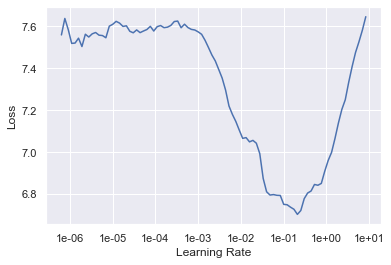

In [40]:
breakpoints = torch.Tensor([250, 500])
model = Model(breakpoints, 1, 20)
learner = Learner(db, model, loss_func=F.l1_loss)
wd = 0
learner.lr_find(wd=wd)
learner.recorder.plot(skip_end=0)

In [49]:
epochs = 20
learner.fit_one_cycle(epochs, 5e-3, wd=wd)

epoch,train_loss,valid_loss,time
0,1.791663,0.292968,00:00
1,1.796273,0.291225,00:00
2,1.792297,0.283456,00:00
3,1.792925,0.290593,00:00
4,1.790994,0.293395,00:00
5,1.795261,0.260295,00:00
6,1.818038,0.334217,00:00
7,1.815125,0.319917,00:00
8,1.801196,0.330876,00:00
9,1.785178,0.317277,00:00


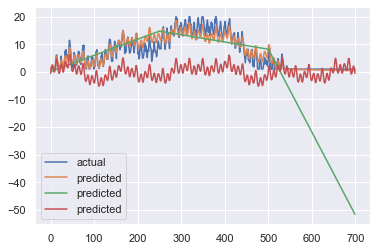

In [50]:
y2 = learner.model(torch.Tensor(t)[:,None])
y3 = learner.model.trend(torch.Tensor(t)[:,None])
y4 = learner.model.seasonal(torch.Tensor(t)[:,None])
plt.plot(t, y, label='actual')
plt.plot(t, y2.detach().cpu().numpy().squeeze(), label='predicted')
plt.plot(t, y3.detach().cpu().numpy().squeeze(), label='predicted')
plt.plot(t, y4.detach().cpu().numpy().squeeze(), label='predicted')
plt.legend()
plt.show()